**Word-level probing experiments**

In [2]:
from conllu import parse
from Bio import Align
aligner = Align.PairwiseAligner()
from conllu.models import TokenList, Token
from Bio.pairwise2 import format_alignment
import os
import torch
import conllu
import tqdm
import numpy as np
from transformers import CamembertModel, CamembertTokenizer, BertModel, BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from time import time
import shutil
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
from scipy.io import savemat
import pickle

import warnings
warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['OPENBLAS_NUM_THREADS'] = '1' # this is very important for sklearn to be one-threaded

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

/usr/local/lib/python3.11/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Mounted at /content/drive


In [3]:
def create_senteval_df(dfs, colname, counterpart_colname = "congruent", tokenlevel=False):
    cong_vs_incong = []
    # dfs = {"tr": X_train, "te": X_test, "va": X_val}
    for df_split, df in dfs.items():
        for row_ix, row in df.iterrows():
            cname = counterpart_colname
            cong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                try:
                    word = row[cname].split()[word_ix]
                except Exception as e:
                    print(row)
                    raise e
                cong = {"split": df_split, "class": cname,
                        "word_ix": word_ix,
                        "word": word,
                        "sent": row[cname]}
            cong_vs_incong.append(cong)
            cname = colname
            incong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                word = row[cname].split()[word_ix]
                incong = {"split": df_split, "class": cname,
                          "word_ix": word_ix,
                          "word": word,
                          "sent": row[cname]}
            cong_vs_incong.append(incong)
    return pd.DataFrame(cong_vs_incong)

def create_senteval_df_sent_struct(dfs, colname, counterpart_colname,
                                   struct, counterpart_struct, tokenlevel=False):
    cong_vs_incong = []
    # dfs = {"tr": X_train, "te": X_test, "va": X_val}
    for df_split, df in dfs.items():
        for row_ix, row in df[df['structure'] == struct].iterrows():
            cname = counterpart_colname
            cong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                try:
                    word = row[cname].split()[word_ix]
                except Exception as e:
                    print(row)
                    raise e
                cong = {"split": df_split, "class": f'{cname}_{struct}',
                        "word_ix": word_ix,
                        "word": word,
                        "sent": row[cname]}
            cong_vs_incong.append(cong)
    for df_split, df in dfs.items():
        for row_ix, row in df[df['structure'] == counterpart_struct].iterrows():
            cname = colname
            incong = {"split": df_split, "class": f'{cname}_{counterpart_struct}',
                      "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                word = row[cname].split()[word_ix]
                incong = {"split": df_split, "class": cname,
                          "word_ix": word_ix,
                          "word": word,
                          "sent": row[cname]}
            cong_vs_incong.append(incong)
    return pd.DataFrame(cong_vs_incong)

def senteval2ud(sentence_row, featname):
    sentence = TokenList()
    for token_ix, token in enumerate(sentence_row["sent"].split()):
        feature = "BORING"
        if token_ix == sentence_row["word_ix"]: feature = "INTERESTING"
        sentence.append(Token(id=token_ix+1, form=token,
                              lemma=None,
                              upos=feature,
                              xpos=None,
                              feats={"feat": sentence_row["class"]},
                              head=None,
                              deprel=None,
                              deps=None,
                              misc=None))
    sentence.metadata={"text": sentence_row["sent"]}
    return sentence

def create_conllu(fname, split=None):
    if isinstance(split, str):
        split={split}
    if split is None:
        split = {"tr","te","va"}
    colnames = ["split", "class", "word_ix", "word", "sent"]
    data = pd.read_csv(fname, delimiter='\t', names=colnames)
    data = data[data.split.isin(split)]
    conllu_column = data.apply(lambda s: senteval2ud(s, fname), axis=1)
    res_fname = fname.replace("senteval", "conllu")
    f = open(res_fname, 'w')
    for sent in conllu_column:
        print(sent.serialize(), file=f)
    f.close()
    return res_fname


# Loading the model

In [4]:
def get_pretrained(model_name, model_class=CamembertModel,
                   tokenizer_class=CamembertTokenizer, device=DEVICE):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    return model, tokenizer

model, tokenizer = get_pretrained(
    'DeepPavlov/rubert-base-cased', model_class=AutoModel,
    tokenizer_class=AutoTokenizer)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def get_average_embs(sentence, layer_inds, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги предложений по слоям. Эмбеддинг предложения == усреднённые эмбеддинги токенов
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds]
        hidden_states = torch.squeeze(hidden_states, dim=1)
        hidden_states = hidden_states[:,1:-1]
        return hidden_states.mean(axis=1)

In [6]:
class RubertMergeTokens:
    def __init__(self, calculateEmbeddings=False):
        self.punct = 0
        self.apo = 0
        self.tokens = []
        self.calculateEmbeddings = calculateEmbeddings
        self.embeddings = []

    def finish(self, *args, **kwargs):
        result = (self.tokens, self.embeddings) if self.calculateEmbeddings else self.tokens
        self.__init__(*args, **kwargs)
        return result

    def next_token(self, token, embedding=None):
        if self.calculateEmbeddings and embedding is None:
            print("Missing features in next_token...")

        if token.startswith('##'):
            self.tokens[-1]+=(token[2:])
            if self.calculateEmbeddings:
                self.embeddings[-1] += embedding

        else:
            self.tokens.append(token)
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)


In [7]:
def get_word_features(toks, token_features, TokenMerger):
    """
    Принимает в качестве аргументов токенизированное предложение и выход модели на нём. Собирает из выхода по токенам выход по словам.
    """

    token_features = token_features[1:-1] # drop CLS and SEP tokens
    word_features = []
    MergeTokens = TokenMerger(calculateEmbeddings=True)
    for i in range(len(token_features)):
        MergeTokens.next_token(toks[i], token_features[i])
    tokens, embeddings = MergeTokens.finish()
    res = torch.stack(embeddings, dim=0)
    return res

def get_word_embs(sentence, word_inds, layer_inds, TokenMerger, model=model, tokenizer=tokenizer, device=DEVICE, is_pretokenized=False):
    """
    Возвращает эмбеддинги слов по слоям. Эмбеддинг слова == усреднённые эмбеддинги токенов, на которые оно разбито (обычно 1 токен).
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt', is_split_into_words=is_pretokenized).to(device)
        # print(tokenizer.convert_ids_to_tokens(tokenizer(sentence)["input_ids"]))
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds] # Convert tuple of layers to torch tensor
        hidden_states = torch.squeeze(hidden_states, dim=1) # Drop batch dimension which is equal to 1
        # hidden_states = hidden_states[1:] # Drop the input layer
        result = []
        toks = tokenizer.tokenize(sentence, is_split_into_words=is_pretokenized)

        for layer in hidden_states:
            word_features = get_word_features(toks, layer, TokenMerger)

            result.append(word_features[word_inds])

        return torch.stack(result, dim=0)

def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False): # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()
    if len(bert_words) != len(ud_tokenization):
        print(bert_words, ud_tokenization)

    ud_features = [[]]
    last_word, last_symbol = 0, 0
    skip_ids = -1
    orig_index = dict()
    for item in ud_tokenization:
        if type(item["id"]) is int and item["id"] <= skip_ids:
            continue

        if bert_words[last_word][last_symbol:].startswith(item["form"]):
            last_symbol += len(item["form"])
            # if last_symbol != 0:
            #     print(last_symbol, bert_words[last_word], item["form"])
            ud_features[-1].append(item)

            orig_index[item["id"]] = len(ud_features) - 1

            if last_symbol == len(bert_words[last_word]): # We've reached the end in the current word
                if len(ud_features[-1]) == 0:
                    print("this is weird...")
                last_word, last_symbol = last_word + 1, 0 # Switch to the next word in bert tokenization
                ud_features.append([])
        else:
            if verbose:
                print("There has been a problem merging", bert_words, "with", ud_tokenization)
                print(bert_words[:last_word])
            return
    ud_features.pop() # Remove the last emtpy features list
    return bert_words, ud_features, orig_index

In [8]:
text = "Котики-то . едят еду".split() #The word camembert is split into multiple tokens => this sentence is good for testing
# text = '''Pour pouvoir mener à bien sa politique dictatoriale, le régime marocain a besoin de stabilité interne pour affronter les "risques externes" engendrés par le conflit du Sahara Occidental.'''
res = get_word_embs(text, [0, 1, 4], [0, 1, 2, 3], RubertMergeTokens, is_pretokenized=True)
res.size()

torch.Size([4, 3, 768])

In [9]:
def first_occurrence(token, elems):
    for el_ix, el in enumerate(elems):
        if token.startswith(el):
            return el_ix

def token_to_char(tokenized, original):

    tok2tokchr = []
    sep = " @mysuperseparator@ "
    tokenized_flat = ''
    for tok_ix, tok in enumerate(tokenized):
        tokenized_flat += sep if tokenized_flat else ''
        for chr_ix in range(len(tok)):
            tok2tokchr.append((tok_ix, len(tokenized_flat)+chr_ix))
        tokenized_flat += tok
    chr2tok = {j:i for i,j in tok2tokchr}

    alignments = aligner.align(tokenized_flat, original)
    alignment = alignments[0]
    tokenized_flatchr2originalchr_indices = list(zip(*alignment.indices.tolist()))
    try:
        tokenized2originalchr_indices = [(chr2tok[i], j) for i,j
                                        in tokenized_flatchr2originalchr_indices
                                         if i in chr2tok]
    except:
        print(chr2tok)

        print(alignment)
        for i,j in tokenized_flatchr2originalchr_indices:
            if i == -1 or j == -1:continue
            print(i,j, end=' ')
            print(chr2tok[i])

        raise Exception()
    return tokenized2originalchr_indices


def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False):
  # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()


    bert_words_text = ' '.join(bert_words)
    ud_tokenization_forms = [el["form"] for el in ud_tokenization]
    ud_tokenization_text = ' '.join(ud_tokenization_forms)

    alignments = aligner.align(bert_words_text, ud_tokenization_text)
    alignment = alignments[0]

    berttok2bertchr_indices = token_to_char(bert_words, bert_words_text)
    bertchr2berttok_indices = {j:i for i, j in berttok2bertchr_indices}
    udtok2udchr_indices = token_to_char(ud_tokenization_forms, ud_tokenization_text)
    udchr2udtok_indices = {j:i for i, j in udtok2udchr_indices}

    bertchr2udchr_indices = list(zip(*alignment.indices.tolist()))
    berttok2udtok_indices = [(bertchr2berttok_indices[i], udchr2udtok_indices[j])
                            for i, j in bertchr2udchr_indices
                            if i in bertchr2berttok_indices \
                             and j in udchr2udtok_indices]
    udtok2berttok_indices = [(j, i) for i, j in berttok2udtok_indices]
    orig_index = {ud_tokenization[ud_ix]["id"]: bert_ix for ud_ix, bert_ix in udtok2berttok_indices}  # we lose values here
    ud_features = []
    for tok_ix in range(len(bert_words)):
        ixes_to_append = {ud_ix for bert_ix, ud_ix in berttok2udtok_indices if bert_ix == tok_ix}
        ud_features.append([ud_tokenization[ix] for ix in ixes_to_append])

        if len(ud_features[-1]) == 0:
            print(alignment)
            print(bert_words[tok_ix], bert_words, ud_tokenization_forms, bertchr2udchr_indices, udtok2berttok_indices, udchr2udtok_indices, bertchr2berttok_indices, sep='\n', end='\n\n')



    return bert_words, ud_features, orig_index

# Loading and parsing datasets

In [10]:
# Token parser is a function mapping a list of lists of word features and a dictionary from original to current index (aka a sentence)
# to a list of lists of indices of words and a list of targets (aka a number of observations)
# [[feats1], [feats2], [feats3.1, feats3.2]], {1:0, 2:1, 3:2, 4:2} -> [[0, 2], [1, 2]], [0, 1]

def create_word_by_word_parser(allowed_upos, target_feature):
    return lambda feats, orig_index: \
        get_data_from_sentence_word_by_word(feats, \
                                            lambda feat: get_data_from_word(feat, allowed_upos, target_feature))


def get_data_from_sentence_word_by_word(feats, word_by_word_function):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        data = word_by_word_function(feats[ind])
        if data is not None:
            word_inds.append([ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(data)
    return word_inds, targets

def get_part_of_speech(feat):
    if len(feat) > 1:
        return None
    feat = feat[0]
    return feat["upos"]

def get_data_from_word(feat, allowed_upos, target_feature):
    if len(feat) != 1: # This is a multiword token, let's skip it for now
        # print(feat)
        # input()

        return None
    feat = feat[0]
    if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
        return feat["feats"][target_feature]
    return None

def get_noun_adjective_dependencies(feats, orig_index):
    word_inds = []
    targets = []
    nouns = []
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "NOUN" or word_feats["upos"] == "PROPN":
            nouns.append(ind)
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "ADJ" and word_feats["deprel"] == "amod":
            if orig_index.get(word_feats["head"]) is not None and orig_index[word_feats["head"]] in nouns:
                word_inds.append([orig_index[word_feats["head"]], ind])
                targets.append(1)
                if len(nouns) != 1:
                    noun_he = nouns[(nouns.index(orig_index[word_feats["head"]]) + 1) % len(nouns)]
                    word_inds.append([noun_he, ind])
                    targets.append(0)

    return word_inds, targets

def get_word_by_word_with_distance(feats, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if ind < max_distance or len(feats[ind - distance]) != 1:
            continue
        feat = feats[ind - distance][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

def get_head(feats, orig_index, ind):
    if len(feats[ind]) != 1 or orig_index.get(feats[ind][0]["head"]) is None:
        return -1
    return orig_index.get(feats[ind][0]["head"])

def get_level_ancestor(feats, orig_index, ind, level):
    if level == 0 or ind == -1:
        return ind
    return get_level_ancestor(feats, orig_index, get_head(feats, orig_index, ind), level - 1)

def get_word_by_word_with_tree_distance(feats, orig_index, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if get_level_ancestor(feats, orig_index, ind, max_distance) == -1:
            continue
        head_ind = get_level_ancestor(feats, orig_index, ind, distance)
        if len(feats[head_ind]) != 1:
            continue
        feat = feats[ind][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([head_ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

In [11]:
def load_word_in_sentence_data(dataset_name, TokenMerger, features_extractor, verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], [], []] # Gather data here, first list contains texts, second contains word indices, third contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        if word_inds: # Let's not add sentences with no features to avoid vain embeddings calculation
            samples[0].append(sentence.metadata["text"])
            samples[1].append(word_inds)
            samples[2].append(targets)

    print(failed, "out of", total, "failed")
    print(total)
    data = pd.DataFrame.from_dict({"text": samples[0], "word_ind": samples[1],
                                   "target": samples[2]})
    print(data.shape)
    return data

def load_separate_word_data(dataset_name, TokenMerger, features_extractor,
                            verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], []] # Gather data here, first list contains word indices, second contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        for ind in range(len(word_inds)):
            words = []
            for word_ind in word_inds[ind]:
                words.append(tokens[word_ind])
            samples[0].append(words)
            samples[1].append(targets[ind])

        sentences -= 1
        if sentences == 0:
            break


    print(failed, "out of", total, "failed")
    data = pd.DataFrame.from_dict({"word": samples[0], "target": samples[1]})
    return data


In [12]:
def logreg(args):
    layer, data = args
    X_train, X_test, y_train, y_test = data
    le = LogisticRegression(tol=0.01, max_iter=300000)
    le = le.fit(X_train, y_train)
    y_pred = le.predict(X_test)
    return layer, accuracy_score(y_test, y_pred), le.n_iter_[0]

def rerun_logregs(data_full, targets_full, runs, threads, frac=1.):
    if frac != 1.:
        data, _, targets, _ = train_test_split(data_full.transpose(1,0,2),
                                               targets_full, train_size=frac,
                                           random_state=42,
                                               stratify=targets_full)
        data=data.transpose(1,0,2)
    else:
        data, targets = data_full, targets_full
    res_ = []
    if threads == 1:
        for layer in range(data.shape[0]):
            t0 = time()
            for _ in range(runs):
                res_.append(logreg((layer, train_test_split(data[layer], targets, train_size=0.7))))
            print(f"Done layer #{layer}/{data.shape[0]} in {time() - t0}s")
    else:
        # We compute the inputs lazily, otherwise all RAM limits would be broken
        global inputs
        inputs = list((layer, train_test_split(data[layer], targets, train_size=0.7)) for run_i in range(runs) for layer in range(data.shape[0]))

        with Pool(threads) as pool:
            # It is important to use imap here and not map, since it avoids computing all inputs at once
            res_ = list(pool.imap(logreg, inputs, chunksize=1))
            # Bigger chunksize should supposedly improve performance, but it doesn't, maybe the tasks are too big for it to be noticeable,
            # however, it does introduce greater RAM usage, so it's not recommended to increase it

    res = [[] for _ in range(data.shape[0])]
    iter_nums = [[] for _ in range(data.shape[0])]
    for layer, acc, iters in res_:
        res[layer].append(acc)
        iter_nums[layer].append(iters)

    return res, iter_nums

def word_in_sentence_experiment(layers, TokenMerger, data_extractor, filename, verbose=False, runs=1, threads=1, portion=1.):
    print("Loading sentences...")
    t1 = time()
    french_gender = load_word_in_sentence_data(filename, TokenMerger, data_extractor)
    print(french_gender.shape)
    all_embs = []
    all_targets = []
    print(f"Took {round(time() - t1)}s")
    print("Getting embeddings...")
    t1 = time()
    for row in french_gender.index:
        # french_gender.loc[row, "word_ind"] is a list of list of indices as there can
        # be multiple observations per sentence and multiple words per observation
        unique_words, indices = np.unique(np.concatenate(french_gender.loc[row, "word_ind"]), return_inverse=True)
        indices_per_obs = []
        sm = 0
        for observ in french_gender.loc[row, "word_ind"]:
            indices_per_obs.append(indices[sm : sm + len(observ)])
            sm += len(observ)

        embs = np.array(get_word_embs(french_gender.loc[row, "text"], unique_words, layers, TokenMerger).cpu())
        for observ in indices_per_obs:
            all_embs.append(np.concatenate(np.swapaxes(embs[:,observ], 0, 1), axis=1))
        all_targets += french_gender.loc[row, "target"]

    all_embs = np.swapaxes(np.stack(all_embs), 0, 1)
    all_targets = all_targets
    print(f"Got {all_embs.shape[0]} layers, {all_embs.shape[1]} entries in the dataset of width {all_embs.shape[2]}", flush=True)

    print(f"Took {round(time() - t1)}s")
    print("Training probing classifiers")
    t1 = time()

    res = rerun_logregs(all_embs, all_targets, runs, threads, frac=portion)

    print(f"Took {round(time() - t1)}s", flush=True)

    return res


# Visualization

In [13]:
def draw_boxplots(ax, df, cleft, cright):
    data = df[(df['title_l']==cleft) & (df['title_r']==cright)]
    ax.set_ylim(ymin=0.5,ymax=1)
    ax.set_yticks(np.arange(0.5,1.01,0.1))
    ax.set_yticklabels([0.5,0.6,0.7,0.8,0.9,1])
    sns.boxplot(data=data, x='layer_num', y='results', color='white', ax=ax, linecolor='black', showfliers=False)

def plot_zmatrix(df_username, folder, figsize=None, conds='4x4'):
    SCALE=4
    rows = []
    bounds = np.arange(0.5, 1, 0.05)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    def draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(index=args[1], columns=args[0], values=args[2])
        if np.any(d.to_numpy()):
            ax = sns.heatmap(d, norm=norm, linewidths=0.0, rasterized=True, **kwargs)

    cm = 1/2.54
    LABELSIZE=4*SCALE
    if conds == '4x4':
      order_li = ["Normal", "Sem Incongruent", "Gram Incongruent", "S&G Incongruent"]
    else:
      order_li = ['congruent_SVO', 'congruent_SVAO', 'congruent_SVOG',
                  'sem_incongruent_SVO', 'sem_incongruent_SVAO', 'sem_incongruent_SVOG',
                  'gram_incongruent_SVO', 'gram_incongruent_SVAO', 'gram_incongruent_SVOG',
                  'sem_gram_incongruent_SVO', 'sem_gram_incongruent_SVAO', 'sem_gram_incongruent_SVOG']
    g = sns.FacetGrid(df_username, col="title_l", row="title_r", height=2*cm*SCALE/0.8, aspect=0.8, margin_titles=True,
                      row_order = order_li,
                      col_order = order_li,
                      sharey=False,
                      gridspec_kws={"wspace":0.15, "hspace":0.1})

    g.map_dataframe(draw_heatmap, "layer_num", "trial_num", "results", cbar=False, cmap="viridis")
    g.set_axis_labels("Layer", "Trial", fontsize=LABELSIZE)
    g.set_titles(col_template="{col_name}", row_template="{row_name}", #size=6*SCALE)
                 size=3*SCALE)

    g.set(xticks=np.arange(0.5, 12.6, 1), yticks=np.arange(0.5, 20, 1))
    g.set_xticklabels(list(range(0,13,1)), ha="center", rotation=0)
    g.set_yticklabels(list(range(1,21,1)), va="center", rotation=0)


    daa = df_username.drop_duplicates(['title_l', 'title_r']).pivot(index='title_l', columns='title_r', values='results')
    ax = sns.heatmap(daa, norm=norm, linewidths=0.0, rasterized=True, ax=g.axes[0][0],
                     cmap='viridis', cbar_kws=dict(location='left', anchor=(5,0.5), shrink=0.8))
    for artist in ax.lines + ax.collections:
        artist.remove()
    for row_ix, row in enumerate(g.axes):
        for col_ix, ax in enumerate(row):
            # ax.set_xlim(0,13)
            if row_ix < col_ix:
                for artist in ax.lines + ax.collections:
                    artist.remove()
                draw_boxplots(ax, df_username, order_li[row_ix], order_li[col_ix])
                ax.set_xlim(-1,13)
                ax.set_ylim(0.5,1.02)
                ax.set_xticks(range(13))
                ax.set_xticklabels(list(range(13)), ha='center')
                if row_ix+1 < col_ix: ax.set_ylabel('')
                else: ax.set_ylabel('Probing accuracy', fontsize=LABELSIZE)


                ax.get_yaxis().set_visible(True)
                ax.get_xaxis().set_visible(True)
                ax.spines[['left']].set_visible(True)
                ax.set_xlabel('Layer', fontsize=LABELSIZE)


            if row_ix != col_ix:
                ax.tick_params(labelbottom=True, labelleft=True,
                               pad=0.1, width=0.05, length=1)
            else:
                if row_ix >= col_ix:
                    ax.get_yaxis().set_visible(False)
                    ax.get_xaxis().set_visible(False)
                    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        # print(ax.get_xlim())

    for text in g._margin_titles_texts:
        text.set_x(1.03)
    g.savefig(folder, bbox_inches='tight')

    return g

def layerwise_RDM(df, order_li, rdm_name, names_dict=None):
  RDM_NN = {}
  if names_dict is not None:
    df['title_l'] = df['title_l'].map(names_dict)
    df['title_r'] = df['title_r'].map(names_dict)
  df_mean = df.groupby(['title_l', 'title_r', 'layer_num']
                     ).mean('results').reset_index()[
                         ['title_l', 'title_r', 'layer_num', 'results']]
  nrows, ncols = 3, 5
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 40))
  bounds = np.arange(0.5, 1, 0.05)
  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

  with pd.ExcelWriter(f'results/RDM_{rdm_name}.xlsx') as writer:
      for layer_num, layer_df in df_mean.groupby('layer_num'):
        data_layer = layer_df.drop_duplicates(['title_l', 'title_r']
                                                )
        data_layer = data_layer.pivot(index='title_l',
                                      columns='title_r', values='results')
        data_layer = data_layer[order_li].loc[order_li]
        data_layer.to_excel(writer, sheet_name = f'Layer {layer_num}')
        RDM_NN[f'layer_{layer_num}'] = np.array(data_layer.values)
        sns.heatmap(data_layer.fillna(0), norm=norm, linewidths=0.0, rasterized=True,
                    square = True, ax=axes[layer_num // ncols, layer_num % ncols],
                    cbar=True, cmap="viridis",)
        axes[layer_num // ncols, layer_num % ncols].set_title(f'Layer {layer_num}', fontsize=30)
        axes[layer_num // ncols, layer_num % ncols].set_ylabel('Condition', fontsize=30)
        axes[layer_num // ncols, layer_num % ncols].set_xlabel('Condition', fontsize=30)
        axes[layer_num // ncols, layer_num % ncols].set_xticklabels(labels = order_li, fontsize=20)
        axes[layer_num // ncols, layer_num % ncols].set_yticklabels(labels = order_li,fontsize=20)
      df[['title_l', 'title_r', 'layer_num', 'trial_num', 'results']
        ].to_excel(writer, sheet_name = 'all_scores', index=False)
      df_mean.to_excel(writer, sheet_name='mean_layer_scores', index=False)
  fig.tight_layout()
  fig.savefig(f'results/layerwise_rdm_{rdm_name}.pdf')
  savemat(f'results/RDM_NN_{rdm_name}.mat', RDM_NN)
  return fig, df_mean

## Experiments

In [14]:
congr_parser = create_word_by_word_parser(["INTERESTING"], "feat")
word_in_sentence_1 = lambda parser, fname: word_in_sentence_experiment(
    list(range(13)), RubertMergeTokens, parser, fname, runs=20, verbose=True, threads=8, portion=1.)

In [ ]:
df = pd.read_csv('../data/stimuli.csv')
df["sentence_id"] = df.sentence_id.astype(int)
df.head(2)

mozgi_data = df
def merge_err_types(s):
    res_dict = {"grammar": "gram_incongruent",
                "semantics_grammar": "sem_gram_incongruent",
                "semantics": "sem_incongruent",
                "normal": "congruent"}
    return res_dict[s]

mozgi_data["error_type"] = mozgi_data.target.apply(merge_err_types)
mozgi_data = mozgi_data.pivot(index='sentence_id', columns='error_type',
                              values='sentence')
mozgi_data.columns = mozgi_data.columns.tolist()
mozgi_data = pd.merge(mozgi_data, df[["sentence_id", "position", "structure"]],
                      on="sentence_id", how='left').drop_duplicates()
mozgi_data.structure = mozgi_data.structure.map(
    {'Subject - Verb - Object': 'SVO',
     'Subject - Verb - Adj - Object': 'SVAO',
     'Subject - Verb - Object - Gen': 'SVOG'})
mozgi_data.head()

X_train, X_test = train_test_split(mozgi_data, test_size=0.4)
X_test, X_val = train_test_split(X_test, test_size=0.5)
dfs = {"tr": X_train, "te": X_test, "va": X_val}
mozgi_data

,sentence_id,congruent,gram_incongruent,sem_gram_incongruent,sem_incongruent,position,structure
0,0,Автобусы проходят массовую дезинфекцию,Автобусы проходят массовую дезинфекцией,Автобусы проходят массовую фортуной,Автобусы проходят массовую фортуну,3.0,SVAO
4,2,Авторы получали подарки,Авторы получали подарками,Авторы получали районах,Авторы получали районы,2.0,SVO
8,3,Авторы получат призы,Авторы получат призах,Авторы получат пунктах,Авторы получат пункты,2.0,SVO
12,4,Адвокат обжаловал решение властей,Адвокат обжаловал решением властей,Адвокат обжаловал воспоминанием властей,Адвокат обжаловал воспоминание властей,2.0,SVOG
16,6,Администратор нажала кнопку сигнализации,Администратор нажала кнопке сигнализации,Администратор нажала родиной сигнализации,Администратор нажала родину сигнализации,2.0,SVOG
...,...,...,...,...,...,...,...
580,326,Цены показывают положительную динамику,Цены показывают положительную динамики,Цены показывают положительную фамилии,Цены показывают положительную фамилию,3.0,SVAO
584,330,Человечество объявляет войну,Человечество объявляет войне,Человечество объявляет рамке,Человечество объявляет рамку,2.0,SVO
588,331,Шведы потерпели поражение,Шведы потерпели поражения,Шведы потерпели чтении,Шведы потерпели чтение,2.0,SVO
592,334,Эксперты нашли следы пота,Эксперты нашли следах пота,Эксперты нашли конкурсами пота,Эксперты нашли конкурсы пота,2.0,SVOG


## 4 x 4 condition analysis

In [16]:
if os.path.exists('4x4'):
  shutil.rmtree('4x4')

os.mkdir('4x4')

conditions = [ "congruent", "gram_incongruent",
              "sem_incongruent", "sem_gram_incongruent"]
structures = mozgi_data.structure.unique()
counter = 0
target_list = []
for condition1 in conditions:
   for condition2 in conditions:
    target1 = f'{condition1}'
    target2 = f'{condition2}'
    if set((target1, target2)) in target_list or target1 == target2:
      continue
    target_list.append(set((target1, target2)))
    congru_incongr_df = create_senteval_df(dfs, condition1, condition2,
                                           tokenlevel=True)
    congru_incongr_df.to_csv(f"4x4/{target1}_VS_{target2}_df.senteval",
                             sep='\t', header=False, index=False)
    congru_incongr_df_conllu_f = create_conllu(
        f"4x4/{target1}_VS_{target2}_df.senteval")#, "te")
    counter += 1

experiments = [os.path.join('4x4', file) for file in os.listdir('4x4') if
               file.endswith('.conllu') and not file.startswith('.')]
results = {}
for experiment in tqdm.tqdm(experiments):
    results[experiment.split('.')[0]] = word_in_sentence_1(congr_parser, experiment)
experiments

["ls: cannot access '*conllu': No such file or directory"]



  0%|          | 0/6 [00:00<?, ?it/s]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 1s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 66s
Training probing classifiers
Took 13s



 17%|█▋        | 1/6 [01:19<06:39, 79.83s/it]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 0s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 49s
Training probing classifiers
Took 10s



 33%|███▎      | 2/6 [02:19<04:32, 68.03s/it]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 0s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 31s
Training probing classifiers
Took 10s



 50%|█████     | 3/6 [03:01<02:48, 56.01s/it]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 0s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 30s
Training probing classifiers
Took 8s



 67%|██████▋   | 4/6 [03:39<01:37, 48.85s/it]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 0s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 27s
Training probing classifiers
Took 9s



 83%|████████▎ | 5/6 [04:15<00:44, 44.33s/it]

Loading sentences...
0 out of 300 failed
300
(300, 3)
(300, 3)
Took 0s
Getting embeddings...
Got 13 layers, 300 entries in the dataset of width 768
Took 30s
Training probing classifiers
Took 11s



100%|██████████| 6/6 [04:56<00:00, 49.42s/it]


['4x4/congruent_VS_gram_incongruent_df.conllu',
 '4x4/congruent_VS_sem_incongruent_df.conllu',
 '4x4/gram_incongruent_VS_sem_gram_incongruent_df.conllu',
 '4x4/gram_incongruent_VS_sem_incongruent_df.conllu',
 '4x4/congruent_VS_sem_gram_incongruent_df.conllu',
 '4x4/sem_incongruent_VS_sem_gram_incongruent_df.conllu']

In [17]:
data_rows = []
for title, res in results.items():
    title = title.split('/')[1].strip('_df')
    for layer_num, layer_results in enumerate(res[0]):
        for trial_num, trial_results in enumerate(layer_results):
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_l": title.split('_VS_')[0],
                "title_r": title.split('_VS_')[1],
                "results": trial_results
            })
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_r": title.split('_VS_')[0],
                "title_l": title.split('_VS_')[1],
                "results": trial_results
            })

df = pd.DataFrame(data_rows)
df = df.sort_values(by=['title_l', 'title_r'])
df = df.reset_index(drop=True)

renamer_di = {
    "gram_incongruent": "Gram Incongruent",
    "sem_incongruent": "Sem Incongruent",
    "sem_gram_incongruent": "S&G Incongruent",
    "congruent": "Normal"
}

df['title_l'] = df['title_l'].apply(lambda s: renamer_di.get(s, s))
df['title_r'] = df['title_r'].apply(lambda s: renamer_di.get(s, s))

df

,layer_num,trial_num,title_l,title_r,results
0,0,0,Normal,Gram Incongruent,0.788889
1,0,1,Normal,Gram Incongruent,0.833333
2,0,2,Normal,Gram Incongruent,0.811111
3,0,3,Normal,Gram Incongruent,0.811111
4,0,4,Normal,Gram Incongruent,0.755556
...,...,...,...,...,...
3115,12,15,Sem Incongruent,S&G Incongruent,0.600000
3116,12,16,Sem Incongruent,S&G Incongruent,0.600000
3117,12,17,Sem Incongruent,S&G Incongruent,0.588889
3118,12,18,Sem Incongruent,S&G Incongruent,0.544444


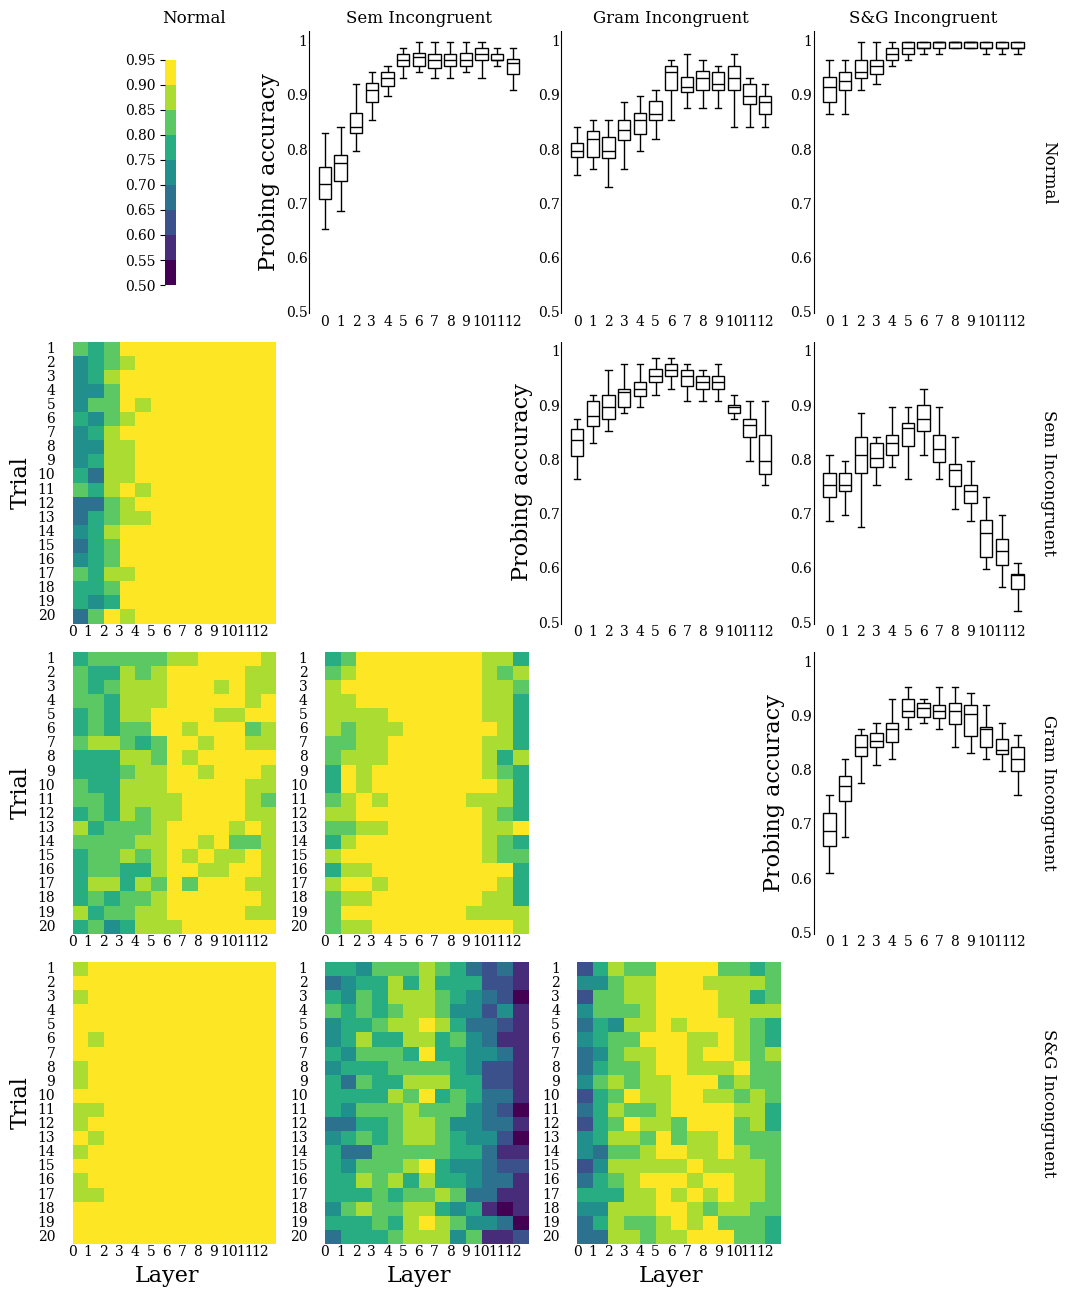

In [18]:
g = plot_zmatrix(df, './res_4x4.pdf')

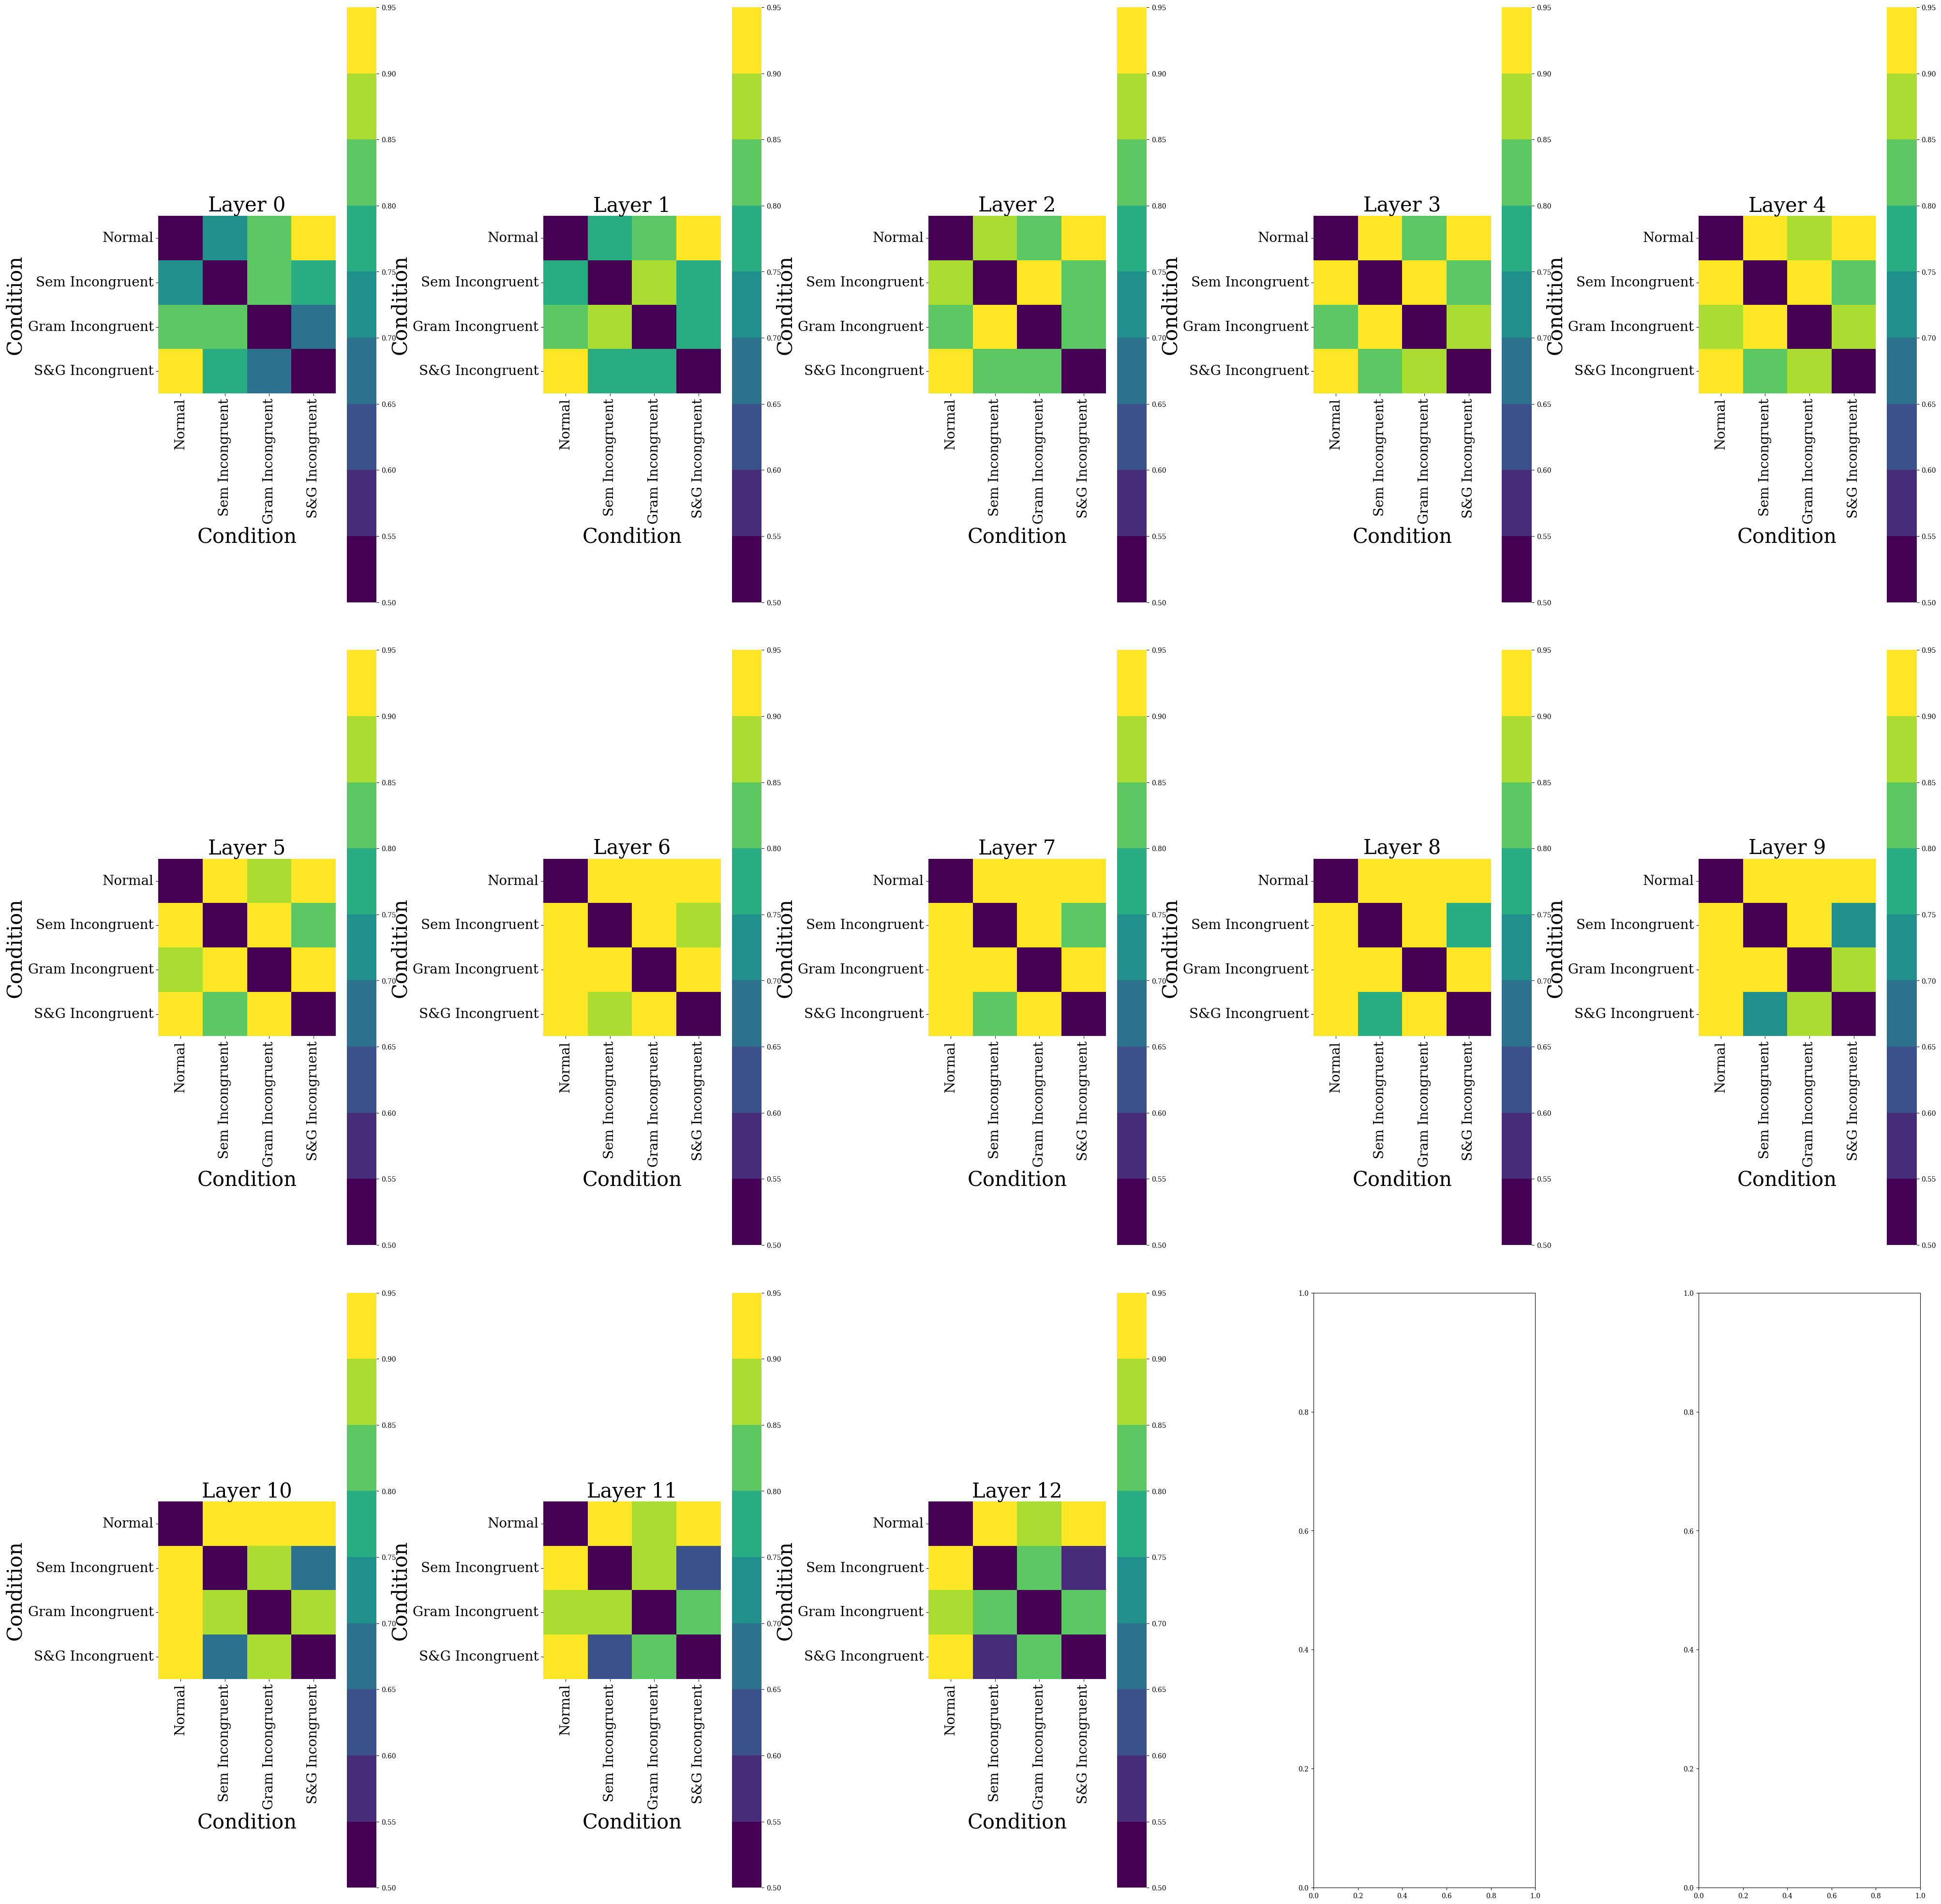

In [19]:
if not os.path.exists('results'):
  os.mkdir('results')

order_conds_4x4 = ['Normal', 'Sem Incongruent', 'Gram Incongruent', 'S&G Incongruent']
rdm_layers_4x4, mean_scores_4x4 = layerwise_RDM(df[:], order_conds_4x4, '4x4', names_dict=None)

## 12 x 12 conditions analysis

In [20]:
if os.path.exists('12x12'):
  shutil.rmtree('12x12')

os.mkdir('12x12')

structures = mozgi_data.structure.unique()
counter = 0
target_list = []
for condition1 in conditions:
    for structure1 in structures:
        for condition2 in conditions:
            for structure2 in structures:
                target1 = f'{condition1}_{structure1}'
                target2 = f'{condition2}_{structure2}'
                if set((target1, target2)) in target_list or target1 == target2:
                    continue
                target_list.append(set((target1, target2)))
                congru_incongr_df = create_senteval_df_sent_struct(
                    dfs, condition1, condition2, structure1, structure2, tokenlevel=True)
                congru_incongr_df.to_csv(f"12x12/{target1}_VS_{target2}_df.senteval", sep='\t', header=False, index=False)
                congru_incongr_df_conllu_f = create_conllu(f"12x12/{target1}_VS_{target2}_df.senteval")#, "te")
                counter += 1


In [21]:
experiments_12x12 = [os.path.join('12x12', file) for file in os.listdir('12x12') if
               file.endswith('.conllu') and not file.startswith('.')]
# experiments = !ls -1 *conllu
results_12x12 = {}
for experiment in tqdm.tqdm(experiments_12x12):
    results_12x12[experiment.split('.')[0]] = word_in_sentence_1(congr_parser, experiment)
experiments_12x12


  0%|          | 0/66 [00:00<?, ?it/s]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



  2%|▏         | 1/66 [00:15<16:23, 15.13s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 4s



  3%|▎         | 2/66 [00:29<15:27, 14.49s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 12s
Training probing classifiers
Took 7s



  5%|▍         | 3/66 [00:48<17:33, 16.72s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 8s



  6%|▌         | 4/66 [01:05<17:12, 16.65s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 8s



  8%|▊         | 5/66 [01:21<16:53, 16.61s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 8s



  9%|▉         | 6/66 [01:37<16:19, 16.33s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 7s



 11%|█         | 7/66 [01:53<16:01, 16.29s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 12%|█▏        | 8/66 [02:08<15:24, 15.93s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 14%|█▎        | 9/66 [02:23<14:54, 15.70s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 15%|█▌        | 10/66 [02:39<14:31, 15.56s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 17%|█▋        | 11/66 [02:53<13:57, 15.23s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 18%|█▊        | 12/66 [03:08<13:32, 15.05s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 20%|█▉        | 13/66 [03:22<13:06, 14.83s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 8s



 21%|██        | 14/66 [03:40<13:32, 15.63s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 23%|██▎       | 15/66 [03:55<13:11, 15.52s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 24%|██▍       | 16/66 [04:09<12:38, 15.18s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 26%|██▌       | 17/66 [04:24<12:14, 15.00s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 4s



 27%|██▋       | 18/66 [04:38<11:44, 14.68s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 29%|██▉       | 19/66 [04:54<11:49, 15.10s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 7s



 30%|███       | 20/66 [05:10<11:47, 15.38s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 8s



 32%|███▏      | 21/66 [05:27<11:48, 15.74s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 13s
Training probing classifiers
Took 6s



 33%|███▎      | 22/66 [05:46<12:19, 16.80s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 4s



 35%|███▍      | 23/66 [05:59<11:20, 15.82s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 36%|███▋      | 24/66 [06:14<10:51, 15.51s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 38%|███▊      | 25/66 [06:29<10:23, 15.21s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 39%|███▉      | 26/66 [06:44<10:05, 15.14s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 41%|████      | 27/66 [06:58<09:37, 14.80s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 42%|████▏     | 28/66 [07:12<09:21, 14.77s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 4s



 44%|████▍     | 29/66 [07:26<08:54, 14.46s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 45%|████▌     | 30/66 [07:41<08:47, 14.66s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 47%|████▋     | 31/66 [07:56<08:30, 14.59s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 48%|████▊     | 32/66 [08:10<08:14, 14.55s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 50%|█████     | 33/66 [08:25<08:08, 14.82s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 52%|█████▏    | 34/66 [08:42<08:06, 15.20s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 53%|█████▎    | 35/66 [08:56<07:43, 14.96s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 4s



 55%|█████▍    | 36/66 [09:10<07:20, 14.68s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 4s



 56%|█████▌    | 37/66 [09:24<07:01, 14.53s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 58%|█████▊    | 38/66 [09:39<06:47, 14.55s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 4s



 59%|█████▉    | 39/66 [09:53<06:27, 14.34s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 61%|██████    | 40/66 [10:07<06:16, 14.47s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 62%|██████▏   | 41/66 [10:23<06:09, 14.79s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 64%|██████▎   | 42/66 [10:38<05:54, 14.79s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 65%|██████▌   | 43/66 [10:53<05:41, 14.83s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 67%|██████▋   | 44/66 [11:08<05:31, 15.07s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 68%|██████▊   | 45/66 [11:24<05:18, 15.18s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 8s



 70%|██████▉   | 46/66 [11:40<05:11, 15.59s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 16s
Training probing classifiers
Took 6s



 71%|███████   | 47/66 [12:03<05:34, 17.63s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 73%|███████▎  | 48/66 [12:18<05:05, 17.00s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 74%|███████▍  | 49/66 [12:33<04:36, 16.25s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 7s



 76%|███████▌  | 50/66 [12:49<04:22, 16.41s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 6s



 77%|███████▋  | 51/66 [13:05<04:04, 16.28s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 16s
Training probing classifiers
Took 7s



 79%|███████▉  | 52/66 [13:28<04:13, 18.10s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 80%|████████  | 53/66 [13:42<03:40, 16.96s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 6s



 82%|████████▏ | 54/66 [13:57<03:15, 16.33s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 7s



 83%|████████▎ | 55/66 [14:12<02:55, 15.96s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 5s



 85%|████████▍ | 56/66 [14:26<02:34, 15.48s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 86%|████████▋ | 57/66 [14:42<02:19, 15.54s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s



 88%|████████▊ | 58/66 [14:57<02:03, 15.49s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 5s



 89%|████████▉ | 59/66 [15:12<01:46, 15.18s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 7s



 91%|█████████ | 60/66 [15:29<01:34, 15.75s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 9s



 92%|█████████▏| 61/66 [15:48<01:23, 16.62s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 7s



 94%|█████████▍| 62/66 [16:04<01:06, 16.64s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 8s



 95%|█████████▌| 63/66 [16:21<00:49, 16.55s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 7s



 97%|█████████▋| 64/66 [16:36<00:32, 16.20s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 8s



 98%|█████████▊| 65/66 [16:52<00:16, 16.16s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 6s


100%|██████████| 66/66 [17:07<00:00, 15.56s/it]


['12x12/congruent_SVO_VS_sem_incongruent_SVAO_df.conllu',
 '12x12/gram_incongruent_SVAO_VS_gram_incongruent_SVOG_df.conllu',
 '12x12/sem_incongruent_SVO_VS_sem_incongruent_SVOG_df.conllu',
 '12x12/gram_incongruent_SVAO_VS_sem_incongruent_SVAO_df.conllu',
 '12x12/gram_incongruent_SVO_VS_sem_gram_incongruent_SVO_df.conllu',
 '12x12/congruent_SVO_VS_gram_incongruent_SVAO_df.conllu',
 '12x12/gram_incongruent_SVAO_VS_sem_gram_incongruent_SVAO_df.conllu',
 '12x12/gram_incongruent_SVO_VS_sem_incongruent_SVAO_df.conllu',
 '12x12/congruent_SVAO_VS_gram_incongruent_SVO_df.conllu',
 '12x12/congruent_SVO_VS_gram_incongruent_SVO_df.conllu',
 '12x12/congruent_SVOG_VS_sem_gram_incongruent_SVO_df.conllu',
 '12x12/congruent_SVO_VS_sem_gram_incongruent_SVAO_df.conllu',
 '12x12/congruent_SVO_VS_sem_gram_incongruent_SVOG_df.conllu',
 '12x12/sem_incongruent_SVOG_VS_sem_gram_incongruent_SVOG_df.conllu',
 '12x12/gram_incongruent_SVAO_VS_sem_gram_incongruent_SVO_df.conllu',
 '12x12/sem_incongruent_SVO_VS_sem_

In [22]:
names_dict = {'congruent_SVAO': 'Norm_SVAO', 'congruent_SVO': 'Norm_SVO', 'congruent_SVOG': 'Norm_SVOG',
       'gram_incongruent_SVAO': 'Gram_SVAO', 'gram_incongruent_SVO': 'Gram_SVO',
       'gram_incongruent_SVOG': 'Gram_SVOG', 'sem_gram_incongruent_SVAO': 'SG_SVAO',
       'sem_gram_incongruent_SVO': 'SG_SVO', 'sem_gram_incongruent_SVOG': 'SG_SVOG',
       'sem_incongruent_SVAO': 'Sem_SVAO', 'sem_incongruent_SVO': 'Sem_SVO',
       'sem_incongruent_SVOG': 'Sem_SVOG'}

data_rows = []
for title, res in results_12x12.items():
    title = title.split('/')[1].strip('_df')
    for layer_num, layer_results in enumerate(res[0]):
        for trial_num, trial_results in enumerate(layer_results):
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_l": title.split('_VS_')[0],
                "title_r": title.split('_VS_')[1],
                "results": trial_results
            })
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_r": title.split('_VS_')[0],
                "title_l": title.split('_VS_')[1],
                "results": trial_results
            })

df_12x12 = pd.DataFrame(data_rows)
df_12x12 = df_12x12.sort_values(by=['title_l', 'title_r'])
df_12x12 = df_12x12.reset_index(drop=True)

df_12x12

,layer_num,trial_num,title_l,title_r,results
0,0,0,congruent_SVAO,congruent_SVO,0.666667
1,0,1,congruent_SVAO,congruent_SVO,0.666667
2,0,2,congruent_SVAO,congruent_SVO,0.700000
3,0,3,congruent_SVAO,congruent_SVO,0.733333
4,0,4,congruent_SVAO,congruent_SVO,0.733333
...,...,...,...,...,...
34315,12,15,sem_incongruent_SVOG,sem_incongruent_SVO,0.966667
34316,12,16,sem_incongruent_SVOG,sem_incongruent_SVO,1.000000
34317,12,17,sem_incongruent_SVOG,sem_incongruent_SVO,1.000000
34318,12,18,sem_incongruent_SVOG,sem_incongruent_SVO,0.966667


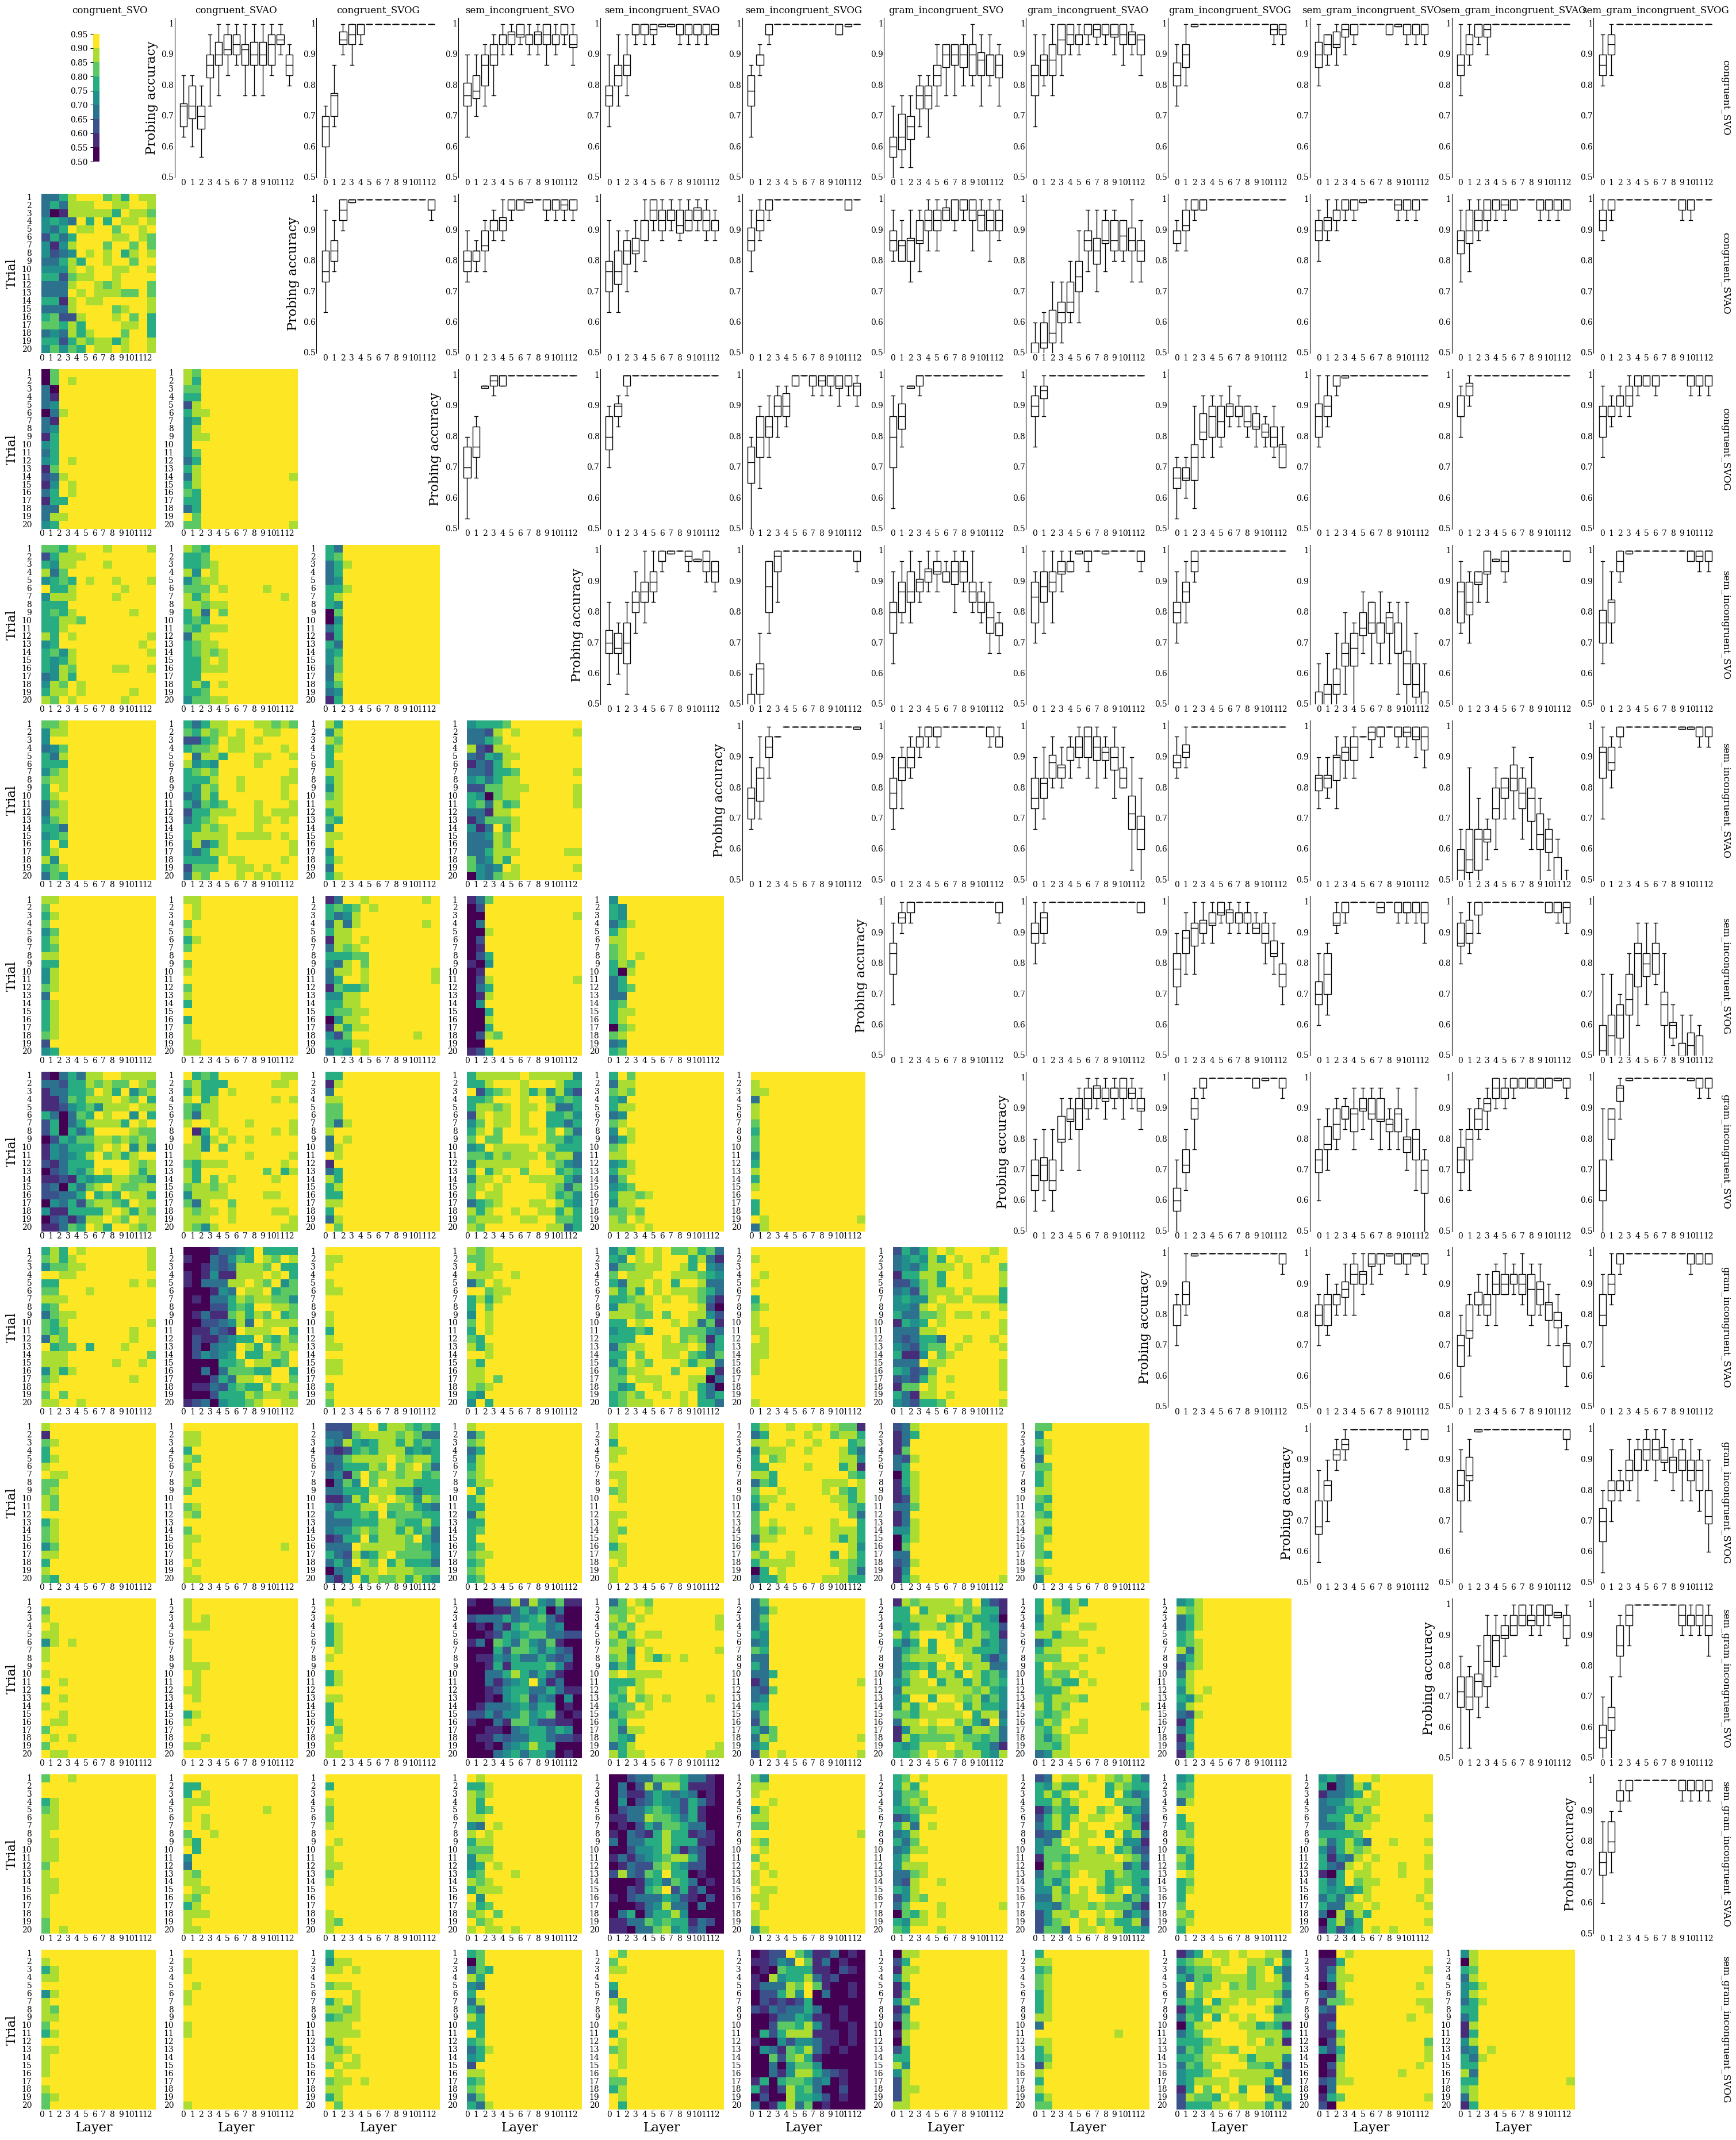

In [23]:
g = plot_zmatrix(df_12x12, './res_12x12.pdf', conds='12x12')

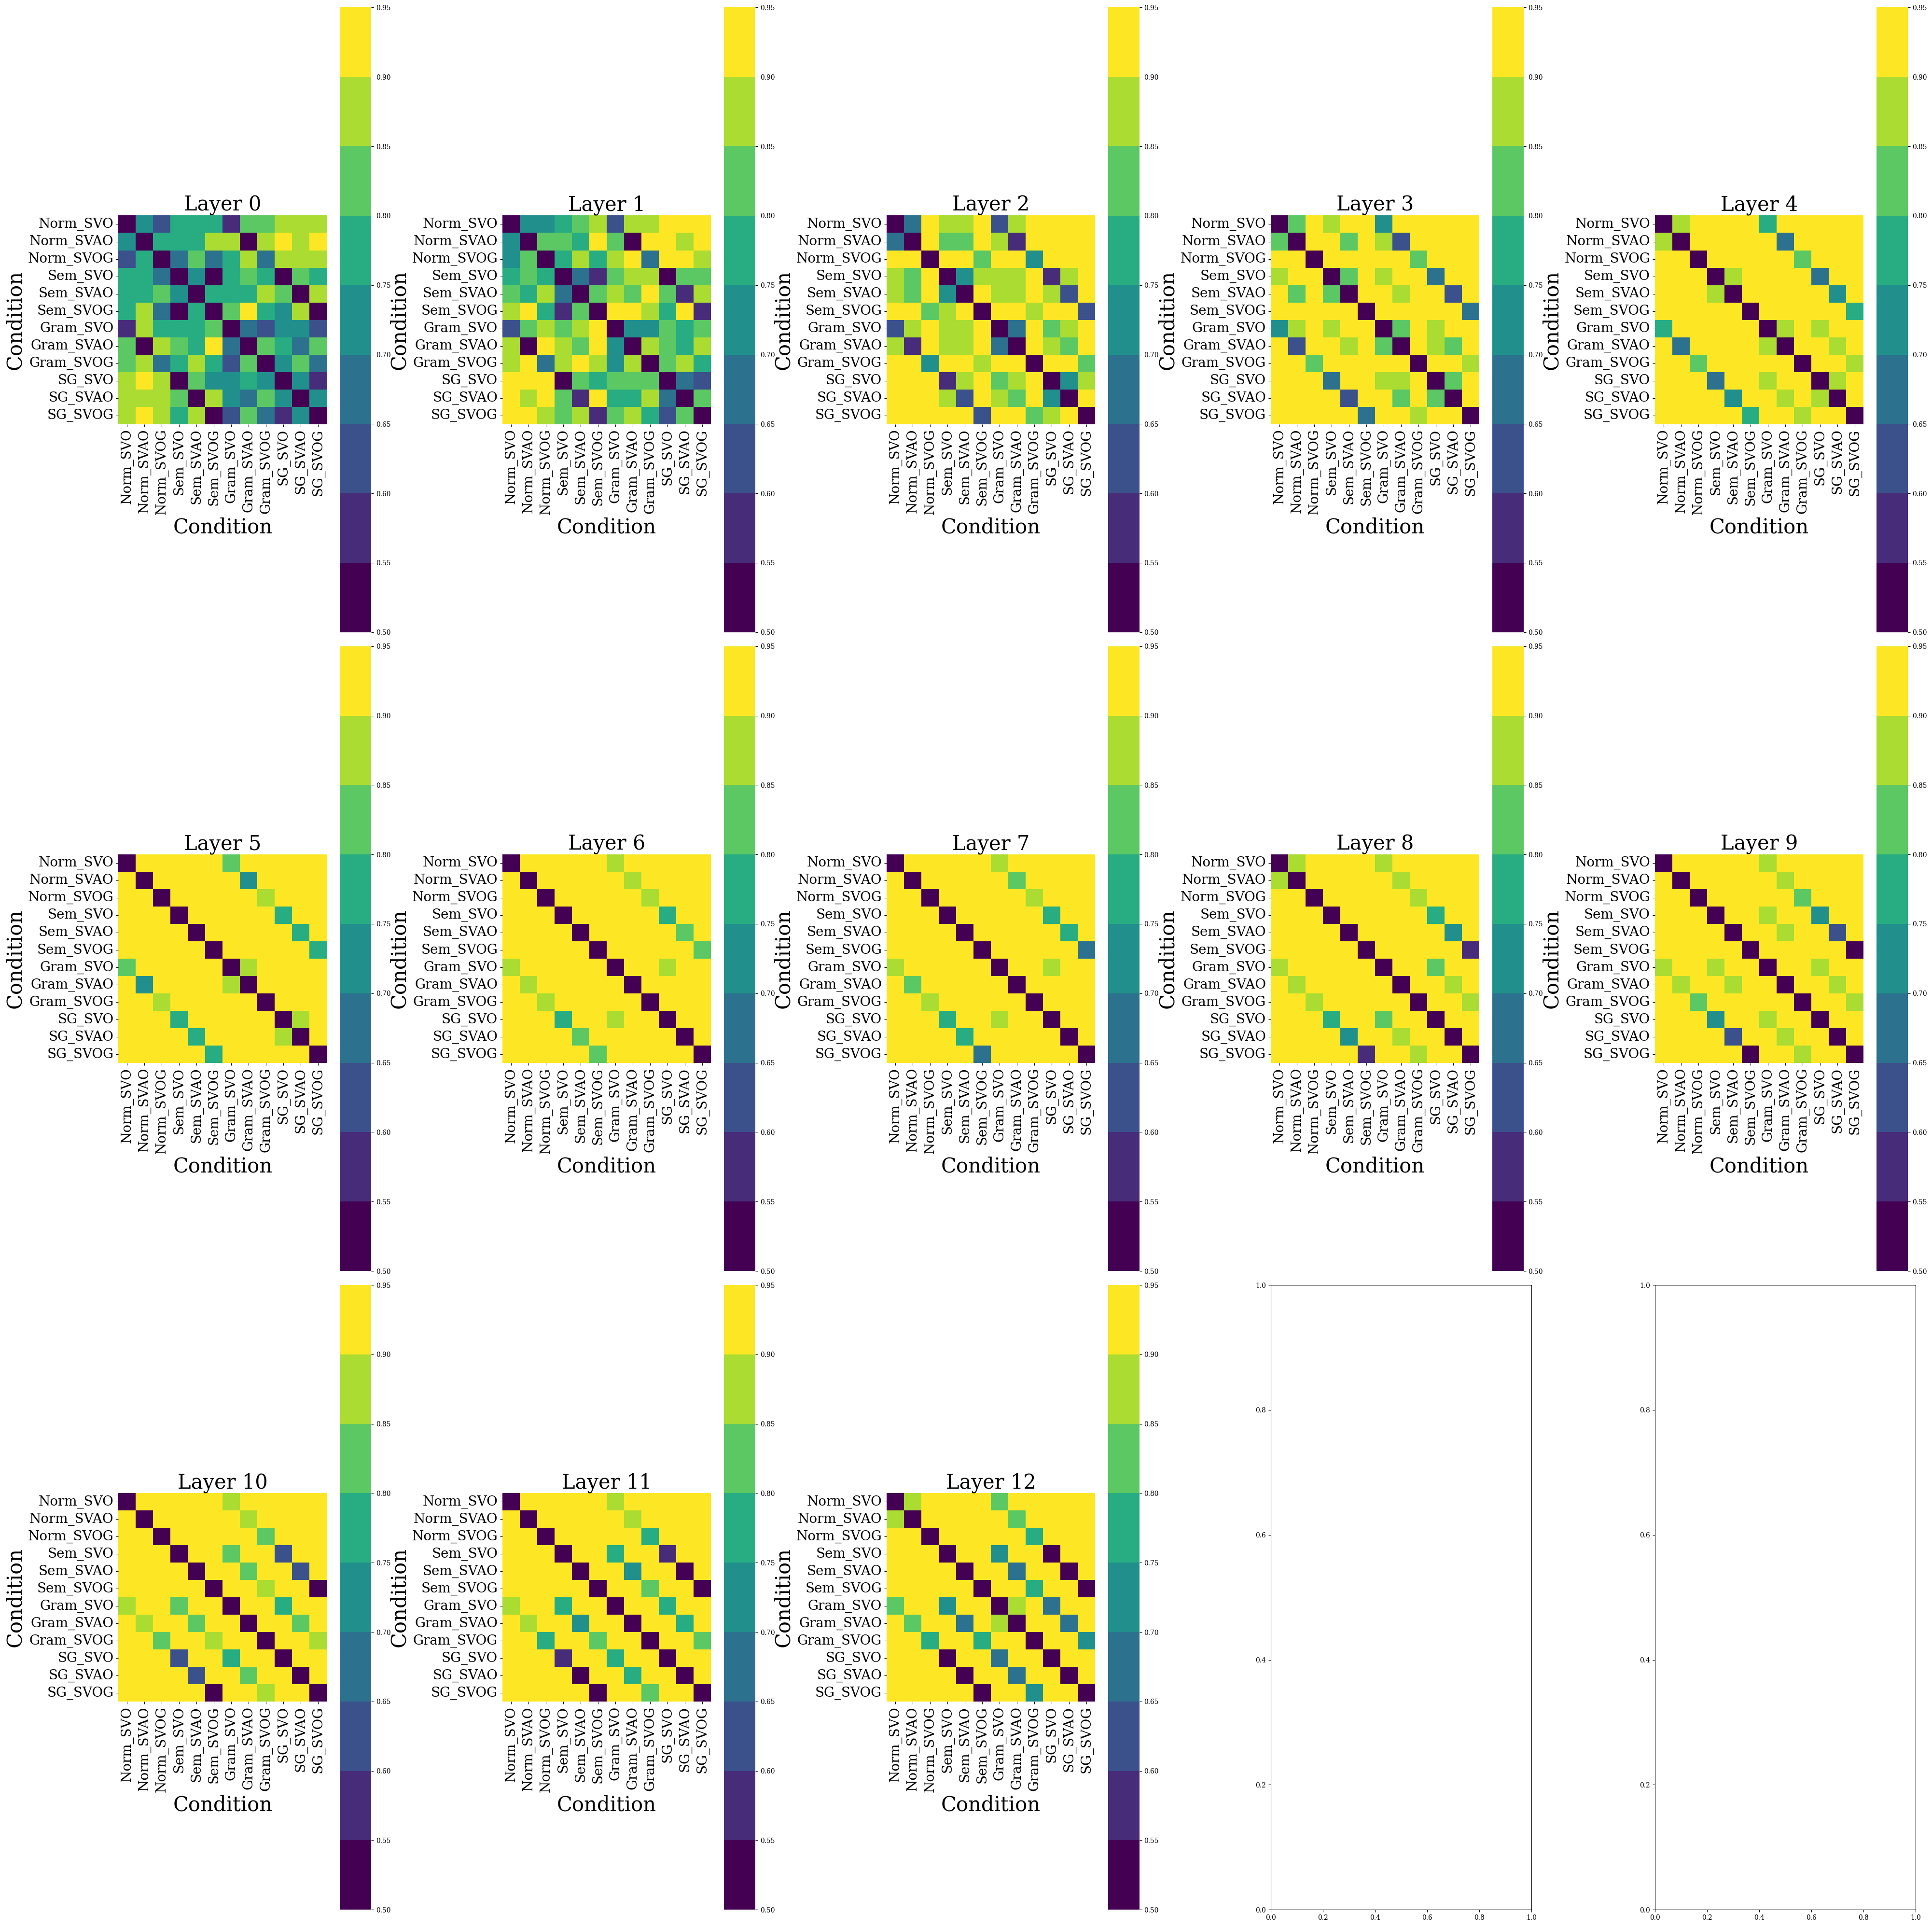

In [24]:
if not os.path.exists('results'):
  os.mkdir('results')
order_conds_12x12 = ['Norm_SVO', 'Norm_SVAO', 'Norm_SVOG',
                     'Sem_SVO', 'Sem_SVAO', 'Sem_SVOG',
                     'Gram_SVO', 'Gram_SVAO', 'Gram_SVOG',
                     'SG_SVO', 'SG_SVAO', 'SG_SVOG']
rdm_layers_12x12, mean_scores_12x12 = layerwise_RDM(
    df_12x12[:], order_conds_12x12, '12x12', names_dict=names_dict)

### Tokenization


In [25]:
def tokenize_word(row, column):
    position = row['position']
    tokenized = tokenizer.tokenize(row[c].split()[int(position)])
    return tokenized

for c in mozgi_data.columns:
    if 'cong' in c and 'tokenized' not in c:
        mozgi_data[f"{c}_tokenized"] = mozgi_data.apply(tokenize_word, args=(c,), axis=1)

In [26]:
for c in mozgi_data.columns:
    if 'tokenized' in c:
        mozgi_data[c.replace('tokenized', "toklen")] = mozgi_data[c].apply(len)
mozgi_data['congruent_toklen'].value_counts()

,count
congruent_toklen,
1,143
2,7


In [27]:
mozgi_data[[c for c in mozgi_data.columns if 'toklen' in c]].value_counts()

congruent_toklen  gram_incongruent_toklen  sem_gram_incongruent_toklen  sem_incongruent_toklen
1                 1                        1                            1                         85
                                           2                            1                         17
                  2                        1                            1                         13
                  1                        2                            2                         11
                  2                        2                            2                          5
                  1                        1                            2                          4
2                 2                        2                            2                          3
1                 1                        3                            3                          2
                  2                        2                            1                          2
                                           1                            2                          2
                                           3                            2                          1
                                           2                            3                          1
2                 1                        1                            1                          1
                                           2                            1                          1
                                                                        2                          1
                  3                        2                            2                          1
Name: count, dtype: int64

- In 85 cases all the tokenizations were of length 1
- In 17 cases semgram introduced tokenization becoming 2
- In 13 cased gram introduced tokenization becoming 2
- In 11 cases sem introduced tokenization becoming 2 (semgram subsequently too)
- In 5  cases all the incongruent tokenizations were of length 2 while congruent was of length 1